In [1]:
import wildqat as wq
import numpy as np
import os
import networkx as nx
import time
import math
import matplotlib.pyplot as plt
import warnings
import random
warnings.filterwarnings('ignore')
aaa = wq.opt()

## グラフ作成

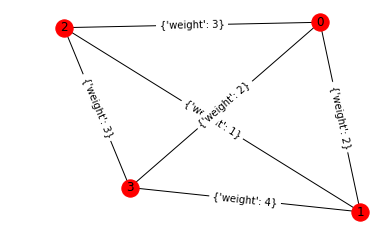

In [2]:
N = 4
G = nx.complete_graph(N)
G.add_weighted_edges_from({(0, 1, 2), (0, 2, 3), (0, 3, 2), (1, 2, 1), (1, 3, 4), (2, 3, 3)})
pos = nx.spring_layout(G)
nx.draw_networkx_edge_labels(G,pos)
nx.draw_networkx(G, pos)

plt.axis("off")
plt.show()

In [3]:
# 距離行列作成
D = np.array(nx.to_numpy_matrix(G))
print(D)

[[0. 2. 3. 2.]
 [2. 0. 1. 4.]
 [3. 1. 0. 3.]
 [2. 4. 3. 0.]]


## 行列Jの計算

In [4]:
#クロネッカーデルタを定義
def delta(i, j):
    if(i == j):
        return 1
    else:
        return 0

#定数A
A = 400

#行列Jを計算
J = np.empty((N, N, N, N), dtype = np.float64)
for a in range(N):
    for t1 in range(N):
        for b in range(N):
            for t2 in range(N):
                J[a, t1, b, t2] =    delta((t1+1)%N, t2) * D[a, b] \
                                    + A * delta(t1, t2) + A * delta(a, b)- 4 * A * delta(a, b) * delta(t1, t2) 
#定数項の計算
C = 2 * A * N

## QUBO行列Qの計算

In [5]:
#Qの計算
Q = np.zeros((N*N,N*N), dtype = np.float64)
x = 0
for a in range(N):
    for t1 in range(N):
        y = 0
        for b in range(N):
            for t2 in range(N):
                if x<=y:
                    Q[x,y] = int(J[a,t1,b,t2])
                else:
                    Q[y,x] += int(J[a,t1,b,t2])
                y = y + 1
        x = x + 1
        
# 初めは0番目のポイント
Q [0,0] -= 10*A
#print(Q)

In [6]:
def cast_result(r):
    # 結果成型
    result = np.empty((N, N), dtype = np.int)
    i = 0
    for x in range(N):
        for y in range(N):
            if(r[i] == 1):
                result[x, y] = 1
            else:
                result[x, y] = 0
            i += 1
    return result
# 結果のチェック
def check_result(result):
    ch = True
    for i in range(N):
        if list(result[i]).count(1)!=1:
            ch = False
        if list(result[:,i]).count(1)!=1:
            ch = False
    return ch

def cal_len(result):
    #距離を計算する
    length = 0
    for t in range(N):
        for a in range(N):
            for b in range(N):
                if(result[a,t] == 1 and result[b,(t+1)%N] == 1):
                    length += D[a,b]
    return length

## 最適化計算（シミュレーティドアニーリング）

In [7]:
aaa.qubo=Q
min =100000000
r2 = []
for i in range(5):
    start = time.time()
    arrangement = aaa.sa()
    elapsed_time = time.time() - start
    print ("SA_time:{0}".format(elapsed_time) + "[sec]")
    #arrangement = arrangement[0]
    result = cast_result(arrangement)
    if check_result(result):
        ll = cal_len(result)
        print(ll)
        if ll<min:
            min = ll
            r2 = result
print("min=",min)

SA_time:2.028649091720581[sec]
8.0
SA_time:1.8986358642578125[sec]
12.0
SA_time:1.9371380805969238[sec]
10.0
SA_time:1.924872875213623[sec]
8.0
SA_time:2.070618152618408[sec]
10.0
min= 8.0


In [8]:
result = np.empty((N, N), dtype = np.int)
i = 0

for x in range(N):
    for y in range(N):
        if(arrangement[i] == 1):
            result[x, y] = 1
        else:
            result[x, y] = 0
        i += 1
print("Result: \n", r2)

Result: 
 [[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]


## ルートの表示

ROUTE: [0 1 2 3 0]


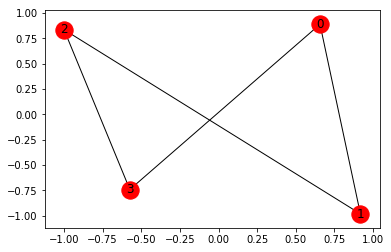

In [9]:
def plot_route2(result, NN):
    routes = []
    edges = []
    route = [np.argmax(row) for row in result]
    for i in range(NN):
        routes.append(route.index(i))
    routes.append(route.index(0))
    routes = np.array(routes)
    print("ROUTE:", routes)
    route_edges = [(routes[n],routes[n+1]) for n in range(len(routes)-1)]
    G.add_nodes_from(routes)
    G.add_edges_from(route_edges)
    edges.append(route_edges)
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_labels(G, pos)
    for ctr, edgelist in enumerate(edges):
        nx.draw_networkx_edges(G, pos, edgelist)
    plt.show()
plot_route2(r2, N)

## Oceanで解く

In [10]:
import dwave_networkx as dnx
import networkx as nx
from dimod import *
from dwave_qbsolv import QBSolv
from dwave.system import DWaveSampler
from dwave.system.composites import EmbeddingComposite, FixedEmbeddingComposite
my_dwave_token = "DEV-df04bbde850ca9170bb81627bc32675b76d18f10"

In [13]:
dictQ = {(i, j): line for i, row in enumerate(Q) for j, line in enumerate(row) if i <= j}
r = EmbeddingComposite(DWaveSampler(token=my_dwave_token)).sample_qubo(dictQ, num_reads=100)
print("Total_real_time ", float(r.info["timing"]["total_real_time"])/1000, " ms")

Total_real_time  24.171  ms


In [15]:
result = np.empty((N, N), dtype = np.int)
i = 0
#print(r)
s = r.first.sample
for i in range(len(s)):
    j = int(i/N)
    k = i%N
    result[j,k]=s[i]
print(result)
if check_result(result):
    ll = cal_len(result)
    print(ll)

[[1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]]
12.0


## 都市数を多くした時

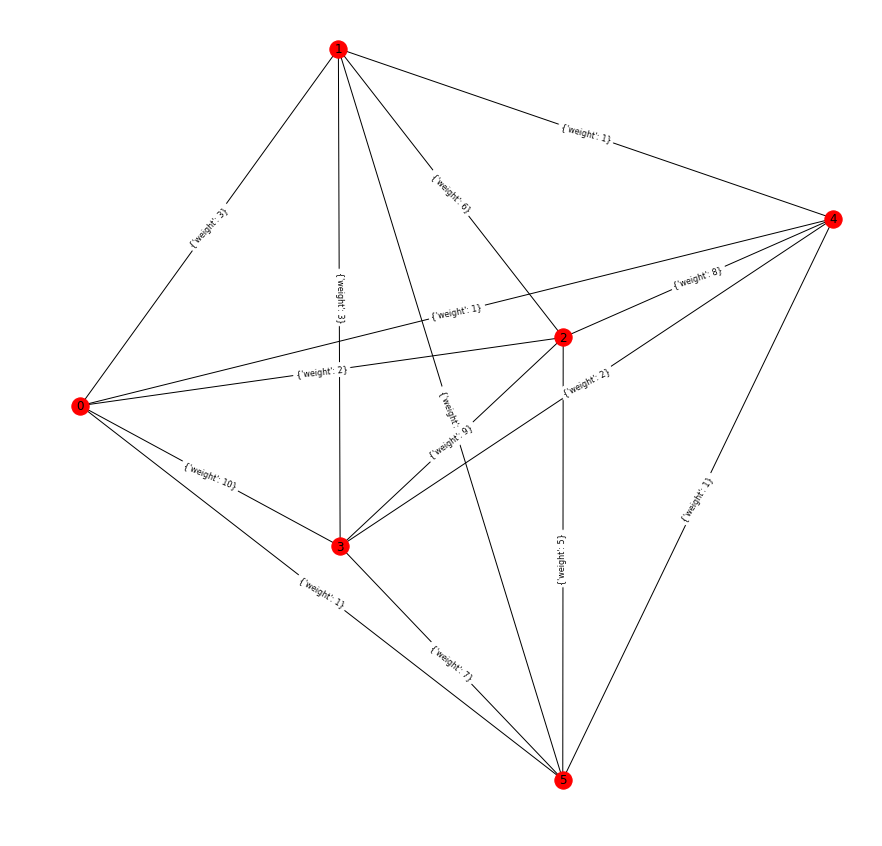

In [13]:
N = 6
G = nx.complete_graph(N)
for (u,v,w) in G.edges(data=True):
    w['weight'] = random.randint(1,10)
pos = nx.spring_layout(G)
plt.figure(figsize=(15,15))
nx.draw_networkx_edge_labels(G, pos, node_size=50, font_size=8)
nx.draw_networkx(G, pos)
plt.axis("off")
plt.show()

In [14]:
# 距離行列作成
D = np.array(nx.to_numpy_matrix(G))
print(D)

[[ 0.  3.  2. 10.  1.  1.]
 [ 3.  0.  6.  3.  1.  2.]
 [ 2.  6.  0.  9.  8.  5.]
 [10.  3.  9.  0.  2.  7.]
 [ 1.  1.  8.  2.  0.  1.]
 [ 1.  2.  5.  7.  1.  0.]]


In [15]:
Q = dnx.algorithms.traveling_salesman_qubo(G)
sampler = EmbeddingComposite(DWaveSampler(endpoint='https://cloud.dwavesys.com/sapi', token=my_dwave_token, solver='DW_2000Q_5'))
response = QBSolv().sample_qubo(Q, solver = sampler, solver_limit=60)
print("Total_real_time ", response.info, " μs")

Total_real_time  {}  μs


In [16]:
ans = np.array(response.record[0][0]).reshape(N,N)
print(ans)

[[0 0 1 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 1 0]
 [0 0 0 1 0 0]]


22.0
ROUTE: [2 1 0 5 4 3 2]


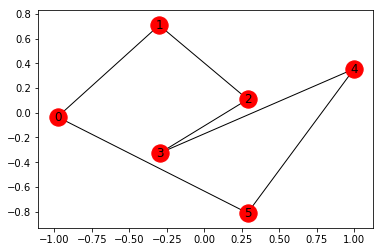

In [17]:
if check_result(ans):
    ll = cal_len(ans)
    print(ll)

    plot_route2(ans, N)
